In [52]:
import shutil
from pathlib import Path 

import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from blur_detector import BlurDetector

In [11]:
def process_image(src):
    img = cv2.imread(str(src))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(img, cv2.CV_64F).var()
    return fm

In [ ]:
def detect_blur(src):
    img = cv2.imread(str(src))
    

In [12]:
df = pd.read_csv('./data/faces.csv', index_col=0)
df.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,filename,character,cast_id
0,1811020,192,0,798,196,916,314,1080,1920,13924,0.007,1,1,"[-0.1581144630908966, 0.11875572055578232, 0.0...",S01E01_192_0.png,NaN,NaN
1,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0...",S01E01_216_0.png,NaN,NaN
2,1811020,216,1,912,17,1205,311,1080,1920,86142,0.042,1,1,"[-0.10312943160533905, 0.1261938065290451, 0.0...",S01E01_216_1.png,NaN,NaN
3,1811020,240,0,1090,106,1384,400,1080,1920,86436,0.042,1,1,"[-0.18763160705566406, 0.08110883831977844, 0....",S01E01_240_0.png,NaN,NaN
4,1811020,240,1,674,522,968,816,1080,1920,86436,0.042,1,1,"[-0.11751651763916016, 0.1057925745844841, 0.0...",S01E01_240_1.png,NaN,NaN


In [15]:
tqdm().pandas()
df['blur'] = df['filename'].progress_map(lambda x: process_image(Path('./data/images/').joinpath(x)))
df.head()

0it [00:00, ?it/s]

  0%|          | 0/249536 [00:00<?, ?it/s]

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,filename,character,cast_id,blur
0,1811020,192,0,798,196,916,314,1080,1920,13924,0.007,1,1,"[-0.1581144630908966, 0.11875572055578232, 0.0...",S01E01_192_0.png,NaN,NaN,45.589042
1,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0...",S01E01_216_0.png,NaN,NaN,7.654599
2,1811020,216,1,912,17,1205,311,1080,1920,86142,0.042,1,1,"[-0.10312943160533905, 0.1261938065290451, 0.0...",S01E01_216_1.png,NaN,NaN,8.256315
3,1811020,240,0,1090,106,1384,400,1080,1920,86436,0.042,1,1,"[-0.18763160705566406, 0.08110883831977844, 0....",S01E01_240_0.png,NaN,NaN,7.682450
4,1811020,240,1,674,522,968,816,1080,1920,86436,0.042,1,1,"[-0.11751651763916016, 0.1057925745844841, 0.0...",S01E01_240_1.png,NaN,NaN,15.825289


In [16]:
not_detected = df[df['character'].isna()]
detected = df[df['character'].notna()]

In [19]:
not_detected['blur'].max()

6769.002374313329

In [20]:
detected['blur'].mean()

31.81459993991953

In [32]:
def save_images(row):
    dst = Path('./data/blurred')
    n = 'blur' if row['blur'] < 100 else 'not_blur'
    dst_dir = dst.joinpath(n)
    if not dst_dir.exists():
        Path.mkdir(dst_dir, parents=True)
    
    fp = dst_dir.joinpath(row['filename']).absolute()
    src = Path('./data/images/').joinpath(row['filename']).absolute()
    shutil.copy(str(src), str(fp))

In [33]:
tqdm().pandas()
df.progress_apply(save_images, axis=1)

0it [00:00, ?it/s]

  0%|          | 0/249536 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
def detect_blur_fft(image, size=60, thresh=10, vis=False):
    # grab the dimensions of the image and use the dimensions to
    # derive the center (x, y)-coordinates
    (h, w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    # compute the magnitude spectrum of the reconstructed image,
    # then compute the mean of the magnitude values
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    # the image will be considered "blurry" if the mean value of the
    # magnitudes is less than the threshold value
    return (mean, mean <= thresh)
    # check to see if we are visualizing our output
    # if vis:
    #     # compute the magnitude spectrum of the transform
    #     magnitude = 20 * np.log(np.abs(fftShift))
    #     # display the original input image
    #     (fig, ax) = plt.subplots(1, 2, )
    #     ax[0].imshow(image, cmap="gray")
    #     ax[0].set_title("Input")
    #     ax[0].set_xticks([])
    #     ax[0].set_yticks([])
    #     # display the magnitude image
    #     ax[1].imshow(magnitude, cmap="gray")
    #     ax[1].set_title("Magnitude Spectrum")
    #     ax[1].set_xticks([])
    #     ax[1].set_yticks([])
    #     # show our plots
    #     plt.show()

82.47300451604134 False


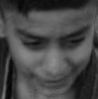

In [71]:
src = Path('./data/images').joinpath(df.iloc[]['filename'])
img = cv2.imread(str(src))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mean, blurry = detect_blur_fft(gray)
print(mean, blurry)
Image.fromarray(gray)

In [50]:
mean

86.59232793594244

In [51]:
blurry

False